In [1]:
# import keras
# import keras.backend as K
# import numpy as np
import matplotlib.pyplot as plt
# from keras.applications import vgg19
# from keras.preprocessing.image import load_img, img_to_array

import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
CONTENT_IMG_PATH = 'pictures/picture.jpg'
style_image_path = 'pictures/style.jpg'

img_height = 400
img_width = 600
col_channels = 3

width, height = load_img(CONTENT_IMG_PATH).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

content_layer = 'block5_conv1'
style_layer = ['block1_conv1', 'block2_conv1', 'block4_conv1', 'block5_conv1']

CONTENT_WEIGHT = 0.025
STYLE_WEIGHT = 1
TV_WEIGHT = 1
ITER = 10

## Plot the images

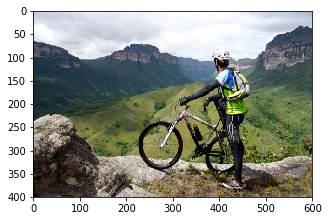

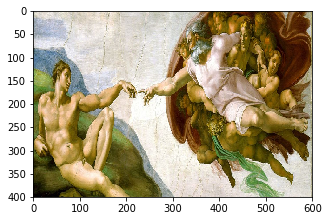

In [3]:
content_img_p = load_img(CONTENT_IMG_PATH, target_size=(img_height, img_width, col_channels))
style_img_p = load_img(style_image_path, target_size=(img_height, img_width, col_channels))

plt.figure(figsize=(5,5))
plt.imshow(content_img_p)
plt.figure(figsize=(5,5))
plt.imshow(style_img_p)

# Preprocess image

In [4]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_img(img_path):
    img = load_img(img_path, target_size=(img_height, img_width, col_channels))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)    
    img = vgg19.preprocess_input(img)
    
    return img

## Deprocess image

In [5]:
# util function to convert a tensor into a valid image	
def deprocess_img_old(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116,779
    x[:,:,2] += 123,68
    
    # BGR >> RGB
    x = x[..., ::-1]

    # clip values in [0, 255] range
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [6]:
def deprocess_image(img):
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_height, img_width))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_height, img_width, 3))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Load the pre-trained model and apply it on the content, style, generated

In [7]:
content_image = K.variable(preprocess_img(CONTENT_IMG_PATH))
style_image = K.variable(preprocess_img(style_image_path))
generated_image = K.placeholder(shape=(1, img_height, img_width, col_channels))

In [8]:
# concatenate in one tensor
input_tensor = K.concatenate([content_image, style_image, generated_image], axis=0)

In [9]:
# load model
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [10]:
# define the content cost
def content_cost(content, generated):
    return K.sum(K.square(generated - content))

def content_loss(content, gen):
    return K.sum(K.square(gen - content))

In [11]:
# define the style cost
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [12]:
def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = gram_matrix(style)
    G = gram_matrix(gen)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

In [13]:
# define the total cost
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [14]:
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
content_img_features = layer_features[0, :, :, :]
gen_img_features = layer_features[2, :, :, :]
loss = loss + CONTENT_WEIGHT * content_loss(content_img_features, gen_img_features)

In [15]:
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for name in feature_layer_names:
    layer_features = outputs_dict[name]
    style_features = layer_features[1, :, :, :]
    gen_img_features = layer_features[2, :, :, :]
    s1 = style_loss(style_features, gen_img_features)
    loss += (STYLE_WEIGHT / len(feature_layer_names)) * s1

In [16]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [17]:
loss = loss + TV_WEIGHT * total_variation_loss(generated_image)

## Evaluating the gradients and loss

In [18]:
grads = K.gradients(loss, generated_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([generated_image], outputs)

In [19]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_height, img_width, 3))
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [20]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## Optimization

In [21]:
evaluator = Evaluator()

# Run L-BFGS optimizer
x = preprocess_img(CONTENT_IMG_PATH)

for i in range(ITER):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=300)
    print('    loss: {}'.format(min_val))
    # Save img
    img = deprocess_image(x)
    imsave('pictures/img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

Step 0
    loss: 611149120.0
     Image saved. Time: 130.21861100196838
Step 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


    loss: 662551936.0
     Image saved. Time: 129.09043073654175
Step 2
    loss: 705802304.0
     Image saved. Time: 127.66861319541931
Step 3
    loss: 709387648.0
     Image saved. Time: 128.41079425811768
Step 4
    loss: 715554240.0
     Image saved. Time: 126.53503513336182
Step 5
    loss: 720814208.0
     Image saved. Time: 125.31834077835083
Step 6
    loss: 718356864.0
     Image saved. Time: 125.52027797698975
Step 7
    loss: 722883968.0
     Image saved. Time: 127.56718945503235
Step 8
    loss: 728164736.0
     Image saved. Time: 126.62424039840698
Step 9
    loss: 730052032.0
     Image saved. Time: 138.88162970542908
